# Worksheet 3b - ARIMAX, SARIMAX and LSTMs

In the previous worksheet, we experimented with ARIMA models. However, one caveat of ARIMA (or similar models), is that it takes only the target variable into consideration, according to the timestamp. In essence, it derives the relationship between the current target variable values and the past variable values.

However, what if we have some other external factors affecting the target values?
This is where *ARIMAX* (AutoRegressive Integrated Moving Average with eXogenous variables) steps in!

ARIMAX extends the capabilities of ARIMA by incorporating external factors or exogenous variables that influence the time series data. It's the bridge that connects the simplicity of ARIMA with the complexity of real-world forecasting, allowing us to tackle more intricate and realistic forecasting challenges.

## Imports

Make sure you have the following libraries installed!

In [448]:
# !pip install scikit-learn
# !pip install keras
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install statsmodels

In [449]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Loading the data

The dataset `electricity.csv` has been given to you. Let's load it using pandas.

In [450]:
import pandas as pd
df = pd.read_csv("electricity.csv")

In [451]:
df.head()

,day,power_consumed,weather_index,holiday_index,maximum_temperature,humidity,wind_velocity,pressure,rainfall
0,2011-11-23,6.952692,1,0,10.36,6.29,2.04,1027.12,13
1,2011-11-24,8.536480,1,0,12.93,8.56,4.04,1027.22,25
2,2011-11-25,9.499781,0,0,13.03,7.24,5.02,1024.47,32
3,2011-11-26,10.267707,0,0,12.96,6.96,5.75,1025.80,41
4,2011-11-27,10.850805,0,0,13.54,5.76,5.48,1021.11,41


### Data Dictionary:

* `power_consumed`: *Target variable*. Electricity consumed by a household.
* `weather_index` : A cluster assigned to type of weather, through previous preprocessing. For instance, cloudy could be 1, sunny could be 2, etc.
* `holiday_index` : 0 if it's a working day, 1 if it's a holiday.
* `maximum_temperature` : Max temperature of the particular day. 
* `humidity` : Humidity measured as dew point.
* `wind_velocity` : Average wind speed.
* `pressure` : Atmospheric pressure in the locality.
* `rainfall` : Average rainfall amount.

We intend to perform electricity usage forecasting over every single day, used by a household. At this stage, a suggestion would be to start thinking about your knowledge with respect to electricity bills. Are there specific months when you'd expect higher power consumption over some other months? Do you think this could be effectively modeled with some time series methods that you have learnt of, in your course?

Remember, we are performing time series analysis here. A general rule of thumb is to have the `time` column as the index column!

In [452]:
df['day'] = pd.to_datetime(df['day'])
df.set_index(['day'],inplace=True)

Before we try to forecast anything, let's go ahead and split the dataset into train-test sets, as discussed in the previous worksheet. 
Remember, since we're dealing with time series data, we will not perform a random split! 

In [453]:
train = df.iloc[0:(len(df)-30)]
test = df.iloc[len(train):(len(df)-1)]

Since this is a small dataset, and is being used only for demonstration purposes, we've used a split of only 30 instances for testing and the rest for training.

In the real world, we'd prefer using a 70-15-15 % split for train-test-val, or 80-20 for train-test, as required by the problem.

In [454]:
train.head()

,power_consumed,weather_index,holiday_index,maximum_temperature,humidity,wind_velocity,pressure,rainfall
day,,,,,,,,
2011-11-23,6.952692,1,0,10.36,6.29,2.04,1027.12,13
2011-11-24,8.536480,1,0,12.93,8.56,4.04,1027.22,25
2011-11-25,9.499781,0,0,13.03,7.24,5.02,1024.47,32
2011-11-26,10.267707,0,0,12.96,6.96,5.75,1025.80,41
2011-11-27,10.850805,0,0,13.54,5.76,5.48,1021.11,41


<Axes: xlabel='day'>

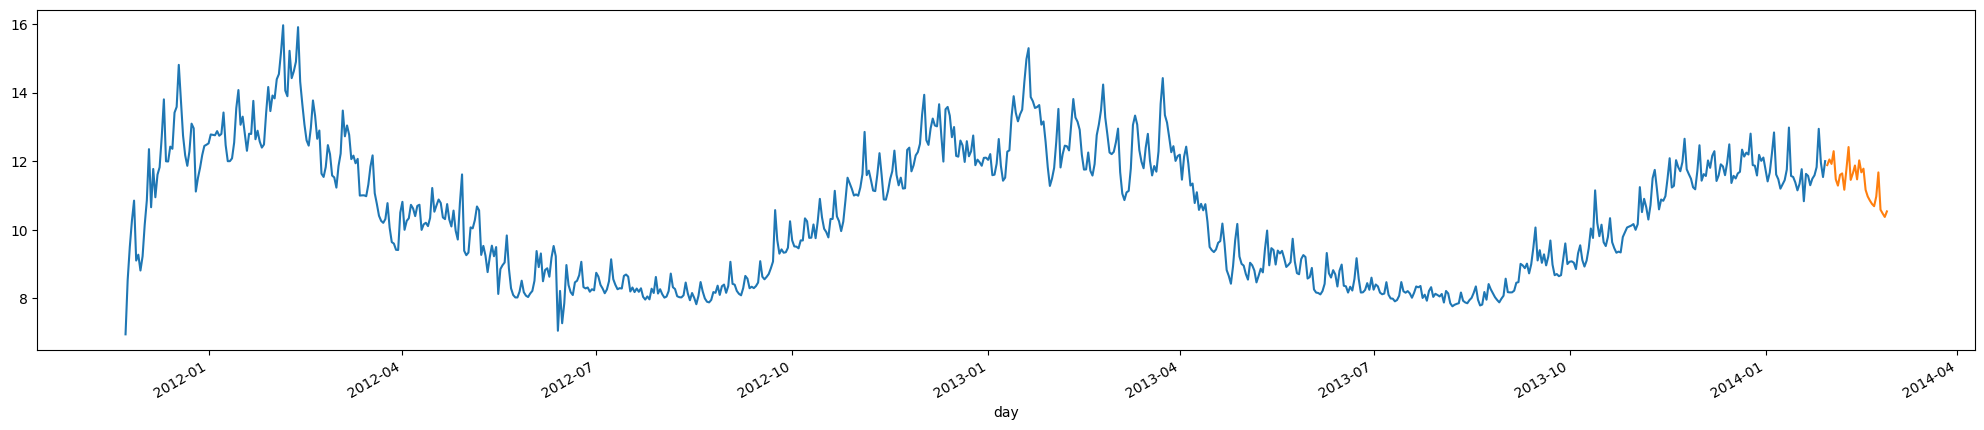

In [455]:
train['power_consumed'].plot(figsize=(25,5))
test['power_consumed'].plot(figsize=(25,5))

## Augmented Dickey-Fuller Test

In [456]:
t = sm.tsa.adfuller(train.power_consumed, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.872794
p-value                          0.344966
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

We can see that $p > 0.05$, hence the data is not stationary. We need to implement some sort of differencing to make the data stationary.   

In [457]:
train['differenced_values'] = train['power_consumed'].diff(1)
train.dropna(inplace=True)

In [458]:
t = sm.tsa.adfuller(train.differenced_values, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.715004e+00
p-value                        3.600554e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64

Single order differencing seems to work here! We can see that $p < 0.05$ now

## Decomposition of elements

In [459]:
s = sm.tsa.seasonal_decompose(train.power_consumed, period=12)

<Axes: xlabel='day'>

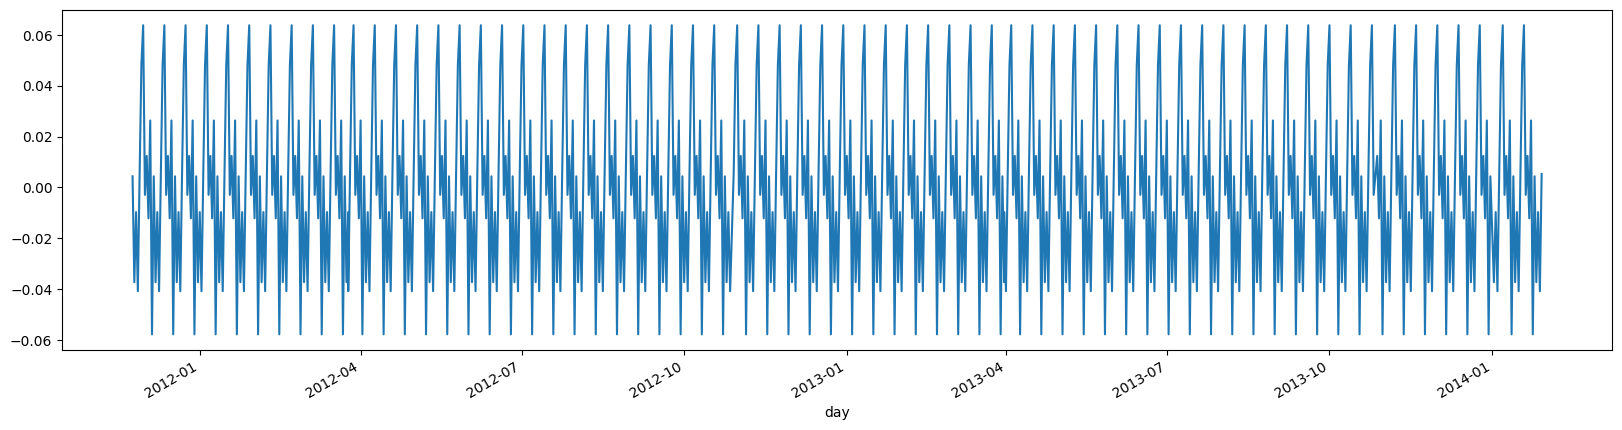

In [460]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='day'>

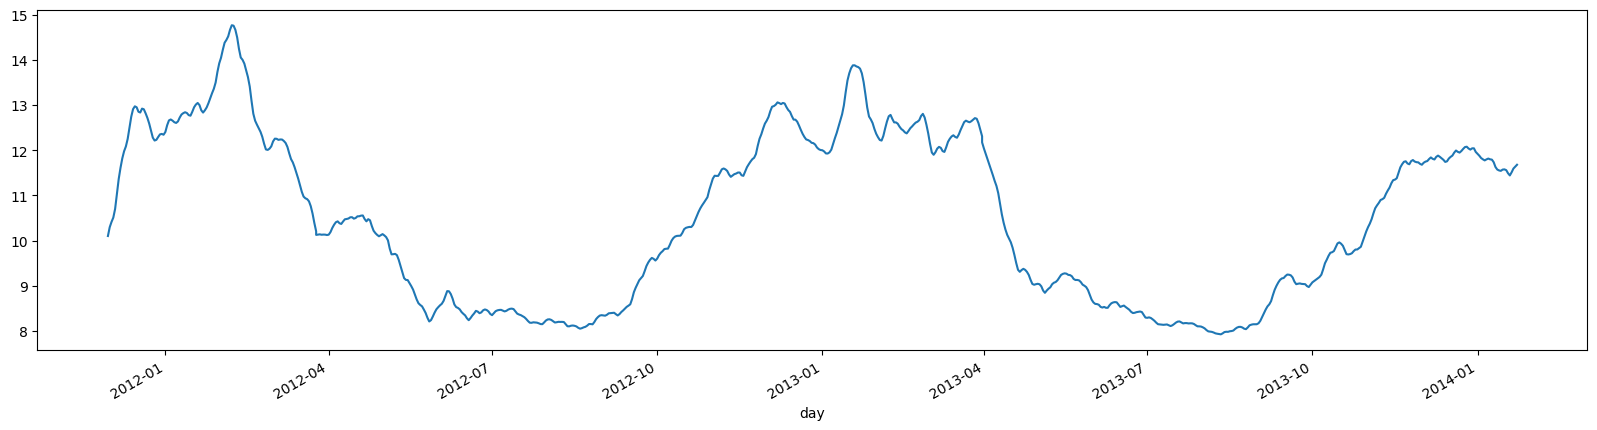

In [461]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='day'>

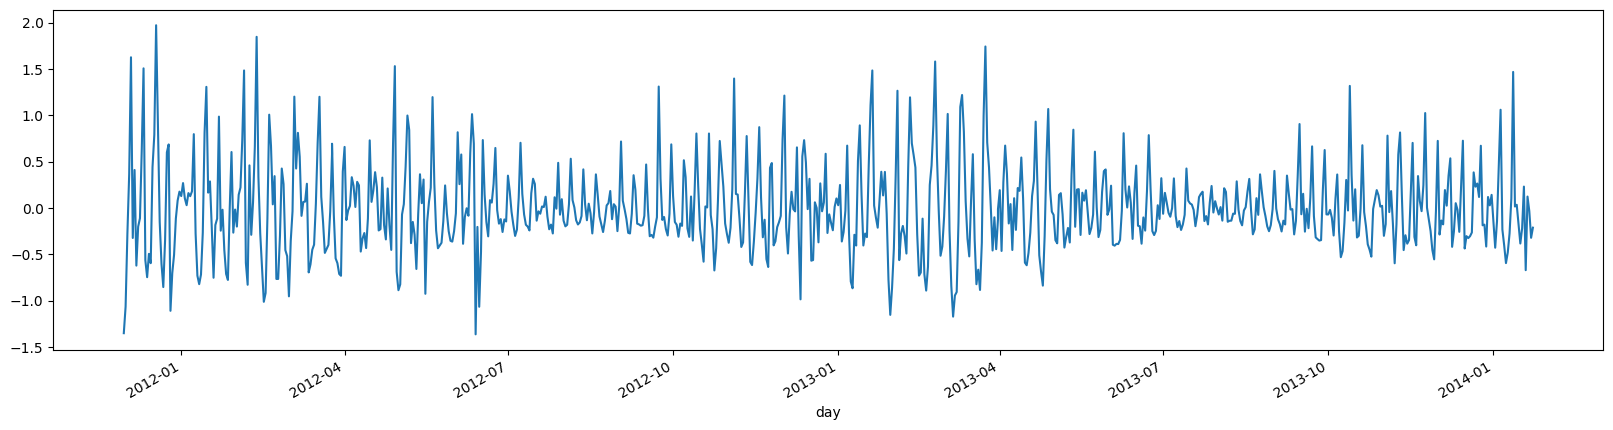

In [462]:
s.resid.plot(figsize=(20,5))

## ARIMAX Model

In [463]:
train.columns

Index(['power_consumed', 'weather_index', 'holiday_index',
       'maximum_temperature', 'humidity', 'wind_velocity', 'pressure',
       'rainfall', 'differenced_values'],
      dtype='object')

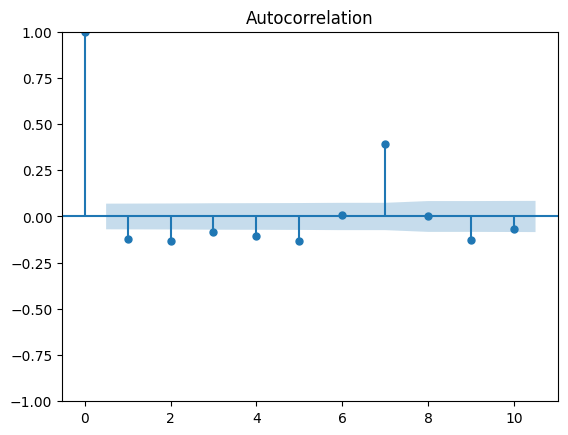

In [464]:
plot_acf(train.differenced_values,lags=10)
plt.show()

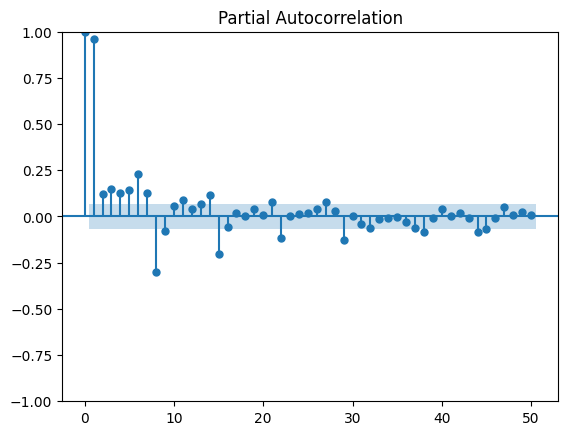

In [465]:
plot_pacf(train.power_consumed,lags=50)
plt.show()

Here, we define an algorithm which takes in a range of values of p, d, q and calculates the AIC metric on a vanilla ARIMA model. 

The **Akaike Information Criterion (AIC)** is a statistical measure used for model selection and comparison in the context of regression analysis and time series modeling.

AIC quantifies the trade-off between a model's goodness of fit and its complexity, penalizing models with too many parameters. It is employed to choose the best-fitting model among a set of candidate models. The model with the lowest AIC value is typically preferred because it represents a good balance between explaining the data and avoiding overfitting.

In [ ]:
#Finding the best value for ARIMA
import warnings
warnings.filterwarnings("ignore")

import itertools 
p=q=range (0,8)
d = range(0,2)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.power_consumed, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic  
              #print(param, model_arima_fit.aic)
       except:
              continue
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data
# It's like the mean squared error in Regression - The smaller the number, the better

In [ ]:
endog = train['power_consumed']
exog = sm.add_constant(train[['weather_index', 'holiday_index',
       'maximum_temperature', 'humidity', 'wind_velocity', 'pressure',
       'rainfall']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,7))
model_fit = mod.fit()
model_fit.summary()

Plotting the predicted values on the train set - shows a decent prediction

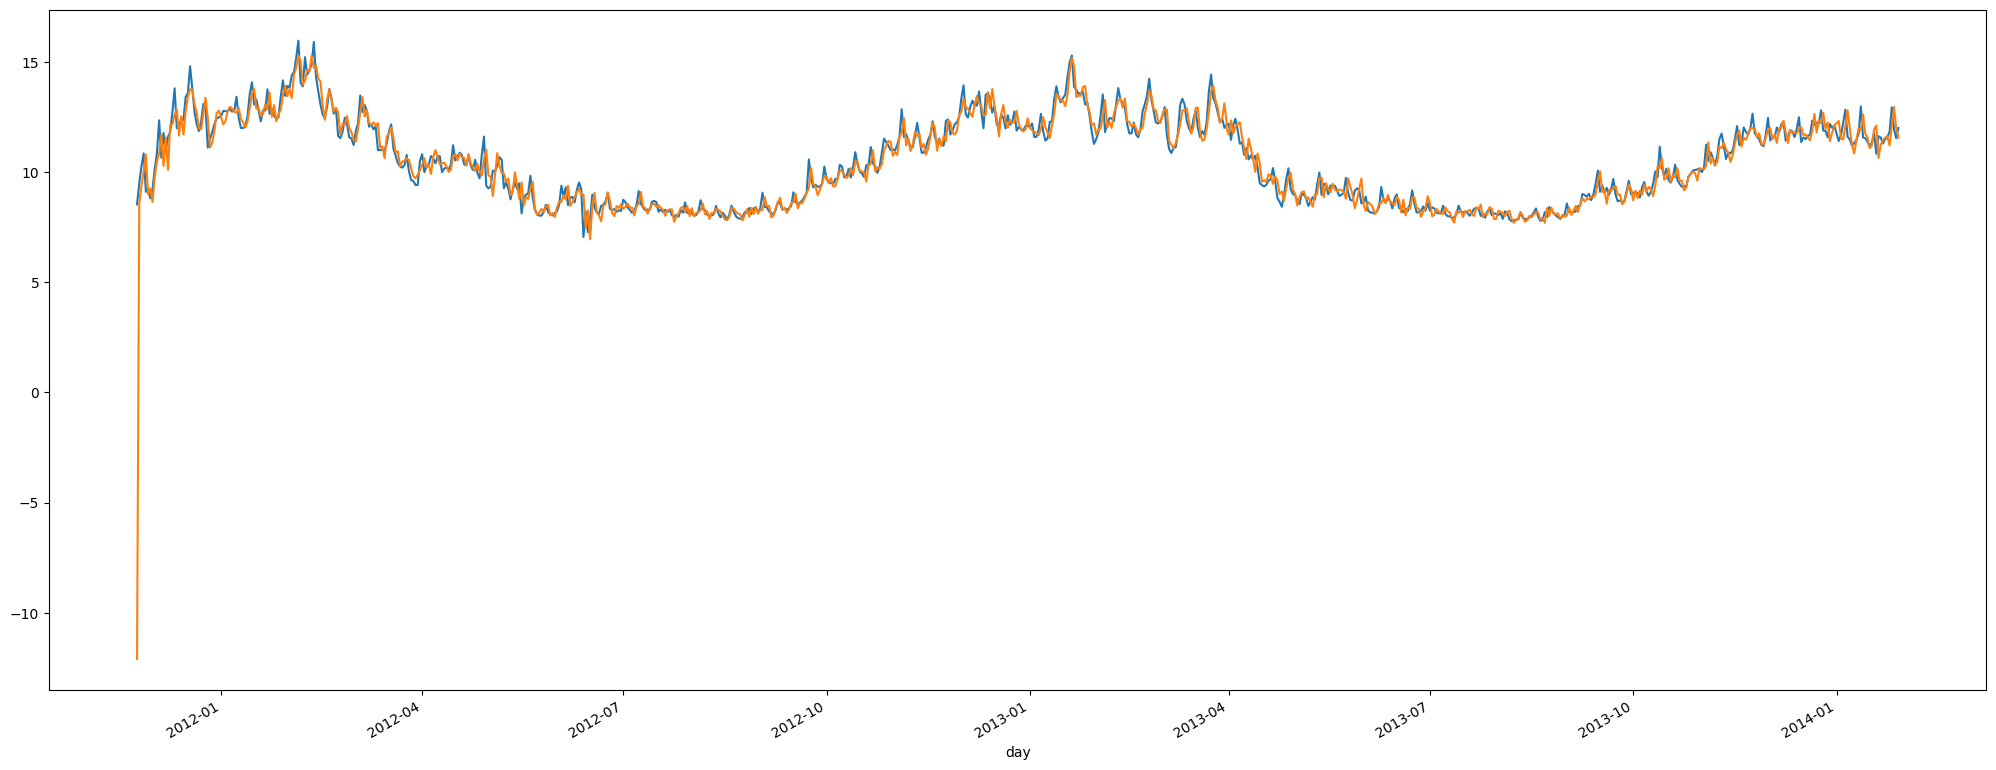

In [468]:
train['power_consumed'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

With this piece of code, we shall perform model inference. 
We'll use our hold-out test set for this. Using the exogenous variables, we'll provide input into our fitted ARIMAX model, and obtain the predcitions for `power_consumed`

In [469]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_index', 'holiday_index', 'maximum_temperature', 'humidity', 'wind_velocity', 'pressure', 'rainfall']]))
test['predicted'] = predict.values
test.tail(5)

,power_consumed,weather_index,holiday_index,maximum_temperature,humidity,wind_velocity,pressure,rainfall,predicted
day,,,,,,,,,
2014-02-23,11.673756,0,0,11.94,6.17,7.10,1010.37,4998,11.574936
2014-02-24,10.586235,0,0,14.23,6.03,5.02,1005.19,4994,11.494668
2014-02-25,10.476498,0,0,11.43,5.06,5.69,1000.65,4995,11.558473
2014-02-26,10.375366,0,0,11.29,2.74,3.82,1012.73,4993,11.540633
2014-02-27,10.537250,0,0,10.31,3.08,4.14,1007.02,4990,11.671498


We've defined 2 metrics here - MAE and MAPE, to quantify our loss here.

In [470]:
MAE = mean_absolute_error(test["power_consumed"], test["predicted"])
RMSE = math.sqrt(mean_squared_error(test["power_consumed"], test["predicted"]))
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.471301473514369
RMSE: 0.5750346886859852


We plot the predicted values vs. the actual values for the test set.

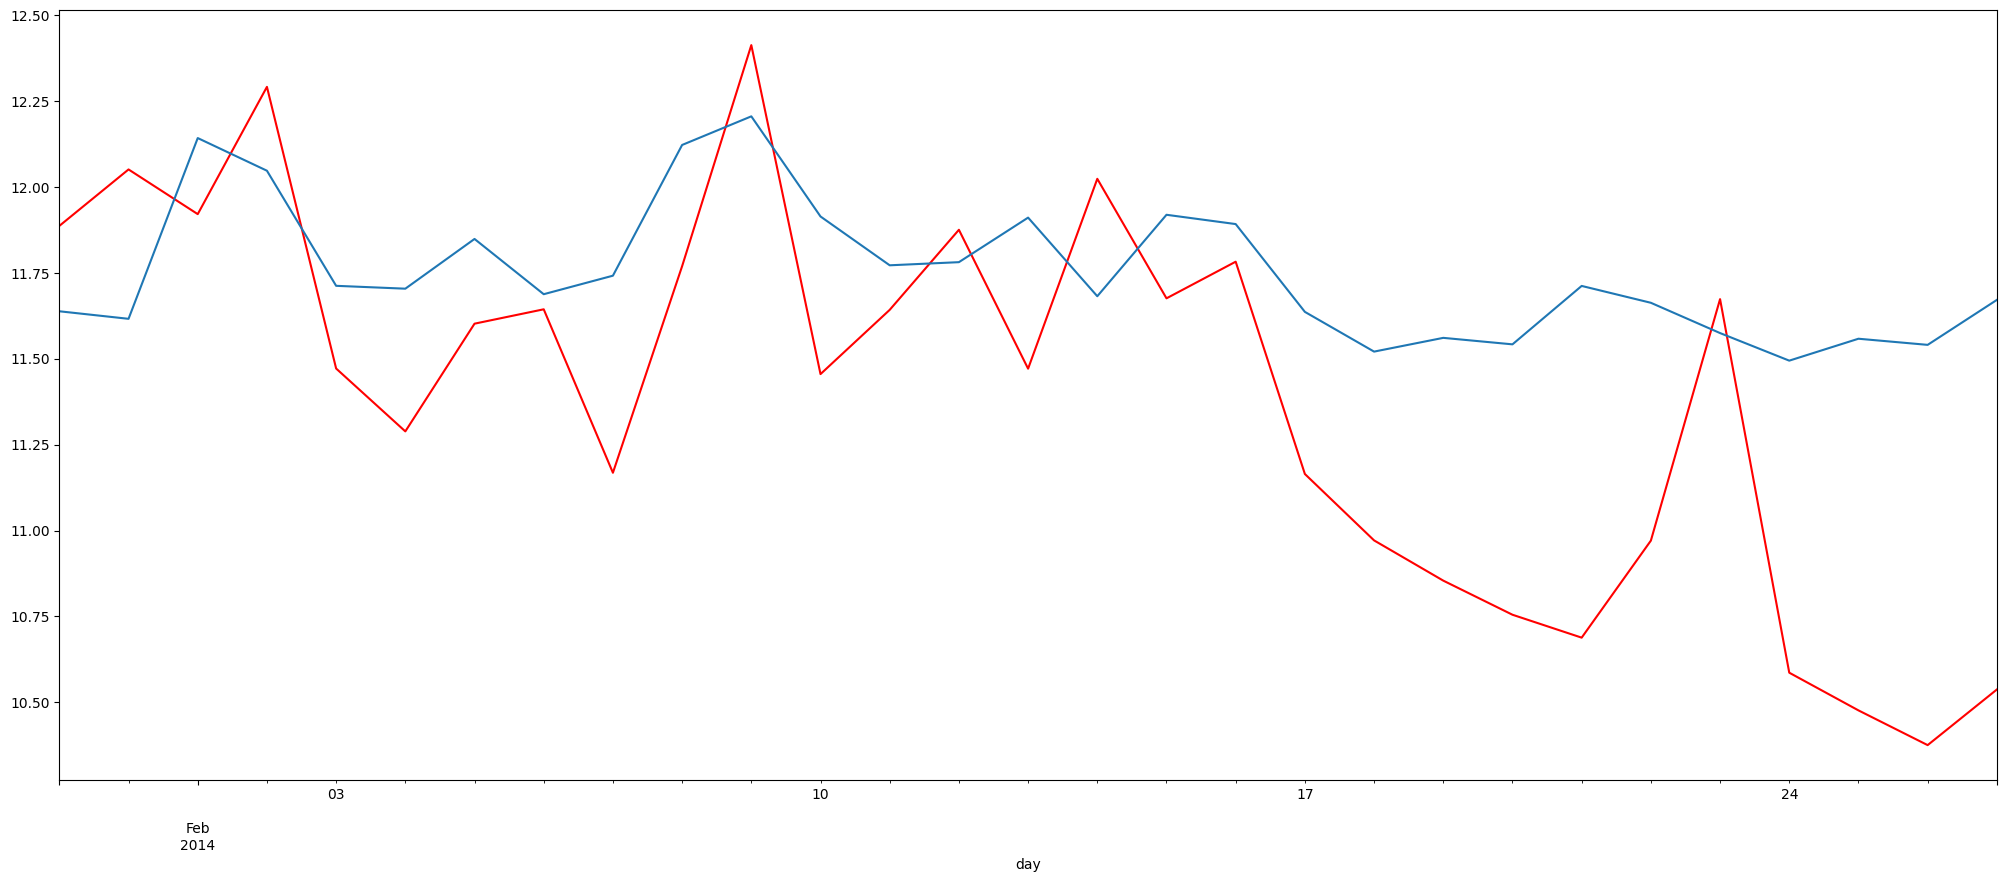

In [471]:
test['power_consumed'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

# Question 1: Your task is to use the above learnings, and apply a SARIMAX model. Do reuse the code, identify a suitable seasonal order, and experiment to find the best performing model! Also, provide your reasoning for choosing your seasonal order!

> Hint: In your model definition step, you'll have to provide a `seasonal_order` parameter along with `order`. 

# LSTMs

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture in deep learning. LSTMs are designed to address the vanishing gradient problem in traditional RNNs, allowing them to effectively capture and model long-range dependencies in sequential data. They have become a crucial tool for tasks like natural language processing, time series forecasting, and sequential pattern recognition.

LSTMs are often used to effectively model complicated time-series problems, so we'll explore this further.

For the scope of this worksheet, we'll only use the target variable and it's lags as input to the LSTM. However, you're encouraged to explore how the entire input dataset can be modeled as input to the model.

Our first task would be to convert our time-series forecasting problem, into a supervised learning problem. Any ideas on how we can achieve this?

Let's first learn the distinction between a time series, and a supervised learning problem.

A time series is a sequence of numbers that are ordered by a time index. This can be thought of as a list or column of ordered values.

A supervised learning problem comprises input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns.

Pandas has a `shift()` function, that we can use to extract **lags** from the target variable. In essence, we want to somehow bring a X->y relation with respect to the target variable, while retaining the time component.

So, what are *lags*?

Lags refer to the practice of shifting a time series data point or variable backward in time by a certain number of time units.

If you're able to understand where this is going now....

We're essentially going to create a mapping such that : 

`var(t - 1) -> var(t)`; which resembles `X -> y` !

We can go further here, and take more lags, such as `var(t - 2), var(t - 3)`, etc.!

Incase you found this prelude a little difficult to follow, consider going through a more detailed write-up here: 

[Machine Learning Mastery's Blog on converting time series to supervised learning](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

## Applying LSTM to our dataset

In [477]:
np.random.seed(11)
dataframe = df.loc[:,'power_consumed']
dataset = dataframe.values
dataset = dataset.astype('float32')

For this demonstration purpose, we'll use lags of 7 days, and convert it into a supervised learning problem. 

Here's a function that's borrowed from the aforementioned blog, that helps us in converting the time series to a supervised problem - 

In [478]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [479]:
new_dataset = series_to_supervised(dataset, 7,1)
new_dataset.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


Just to give a taste of multivariate time-series forecasting using LSTMs - we'll use `weather_index` and `holiday_index` in our input to the model as well:

In [480]:
new_dataset['weather_index'] = df.weather_index.values[7:]
new_dataset['holiday_index']= df.holiday_index.values[7:]

In [481]:
new_dataset = new_dataset.reindex(['weather_index', 'holiday_index','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
new_dataset = new_dataset.values

**Remember - we cannot use DataFrames, as LSTMs (and most other deep learning models) only accept tensors as input!**

In [483]:
type(new_dataset)

numpy.ndarray

We'll scale our features between 0 and 1 - this would be to help the process of gradient descent.

In [485]:
scaler = MinMaxScaler(feature_range=(0, 1))
new_dataset = scaler.fit_transform(new_dataset)

We'll split our dataset into train and test, as done for ARIMAX. Remember, it is still inherently a time series problem, so we will not use a random split.

In [486]:
train_lstm = new_dataset[:(len(new_dataset)-30), :]
test_lstm = new_dataset[(len(new_dataset)-30):len(new_dataset), :]

We adjust the labels, such that `train_X` and `test_X` contain the features, and `train_Y`, `test_Y` contain the target

In [487]:
train_X, train_y = train_lstm[:, :-1], train_lstm[:, -1]
test_X, test_y = test_lstm[:, :-1], test_lstm[:, -1]

The input to a LSTM is 3D - in this format: (samples, timesteps, features). We'll go ahead and reshape our train and tests sets as such

In [488]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


## LSTM Modeling!

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

## LSTM Inferencing (Model Prediction)

Since we went through the whole charade of Scaling our values - making a prediction isn't completely straightforward.
We need to invert the scaling, in order to obtain the correct forecast value.

In [490]:
# make a prediction
yhat = model.predict(test_X)

1/1 [==============================] - 0s 150ms/step


In [491]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [492]:
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [493]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

### Checking the performance of the model

In [498]:
act = [i[0] for i in inv_y] # last element is the predicted power consumption
pred = [i[0] for i in inv_yhat] # last element is the actual power consumption

In [499]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(act, pred)
rmse = math.sqrt(mean_squared_error(act, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.09241764868538539
RMSE: 0.24875282808247645


# Question 2: Can we use accuracy as a metric for this particular problem? Why or why not?

# Question 3: When can LSTMs outperform ARIMA, ARIMAX or SARIMAX models? Is it worth the computational expense to fit an LSTM over a traditional time series model?

# Question 4: What can you elucidate about the interpretability of ARIMA/ARIMAX vs LSTMs?

Hint: Think black-box models

### Congratulations on making it to the end of the worksheet! I hope you have a much better understanding of modeling the time-series workflow, and applications of Deep Learning methods too!

## Incase you want to explore further, Facebook Prophet is a great time series model as well to have in your toolbox!
## Read more [here!](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet)